In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import plasma
from noise_correlations import discriminability, null_models, plot, utils
from imp import reload
from scipy.stats import special_ortho_group

# Subsampling

In [58]:
reload(utils)
rng = np.random.RandomState(20190214)

ambient_dim = 100
var = 1.
corr = .1
mu0 = np.concatenate([np.ones(1), -np.ones(ambient_dim-1)]) + rng.randn(ambient_dim) / 10000
mu1 = np.concatenate([-np.ones(1), np.ones(1), -np.ones(ambient_dim-2)]) + rng.randn(ambient_dim) / 10000
if not np.allclose(np.dot(mu1 - mu0, np.ones(ambient_dim)), 0, atol=.01):
    raise ValueError
cov0 = utils.uniform_correlation_matrix(ambient_dim, var, corr, noise_std=.001, rng=rng)
es = np.linalg.eigvalsh(cov0)
add = np.diag(np.concatenate([np.logspace(np.log10(es.min()), np.log10(es.max() / 4.), es.size - 1), np.array([0.])]))
cov0 += add
cov1 = cov0.copy()
#cov0 = np.diag(np.linspace(1, 10, ambient_dim))
#cov0 = np.diag(np.logspace(-2, 2, ambient_dim))

n_rots = 25
n_trials = 100
n_sample_dims = 7
n_null_samples = 1000

sample_dims = np.unique(np.logspace(1, np.log10(ambient_dim * .9), n_sample_dims, dtype=int))
sample_dims = np.unique(np.linspace(10, ambient_dim * .9, n_sample_dims, dtype=int))
n_sample_dims = sample_dims.size
print(sample_dims)

[10 23 36 50 63 76 90]


# LFI

In [60]:
ambient_vals = np.zeros(n_rots * 100)
ambient_vals_sel = np.zeros(n_rots)
ambient_ps_sel = np.zeros(n_rots)
sample_vals = np.zeros((n_rots, n_sample_dims, n_trials))
sample_ps = np.zeros((n_rots, n_sample_dims, n_trials))

for ii in range(n_rots * 100):
    _, covp = null_models.random_rotation(mu0, cov0, rng=rng)
    val = discriminability.lfi(mu0, covp, mu1, covp)
    ambient_vals[ii] = val

high_d_covs = []
idx = 0
while idx < n_rots:
    _, covp = null_models.random_rotation(mu0, cov0, rng=rng)
    val = discriminability.lfi(mu0, covp, mu1, covp)
    p = np.mean(ambient_vals >= val)
    if p < .05:
        if rng.rand() > np.sqrt(np.sqrt(p)):
            high_d_covs.append(covp)
            ambient_vals_sel[idx] = val
            idx += 1
ambient_ps_sel[:] = (ambient_vals[np.newaxis] >= ambient_vals_sel[:, np.newaxis]).mean(axis=1)

for jj, dim in enumerate(sample_dims):
    print(dim)
    sog = special_ortho_group(dim=dim)
    Rs = []
    for nn in range(n_null_samples):
        Rs.append(sog.rvs(random_state=rng))
    for ii in range(n_rots):
        covp = high_d_covs[ii]
        for kk in range(n_trials):
            (sample_mu0, sample_mu1), sample_covp = utils.subsample_cov([mu0, mu1], covp, dim, rng)
            val = discriminability.lfi(sample_mu0, sample_covp, sample_mu1, sample_covp)
            null_vals = np.zeros(n_null_samples)
            for nn in range(n_null_samples):
                R = Rs[nn]
                sample_covp = R.dot(sample_covp).dot(R.T)
                null_vals[nn] = discriminability.lfi(sample_mu0, sample_covp, sample_mu1, sample_covp)
            sample_vals[ii, jj, kk] = val
            sample_ps[ii, jj, kk] = np.mean(null_vals >= val)

10
23
36
50
63
76
90


In [61]:
ambient_ps_sel[ambient_ps_sel == 0] = ambient_ps_sel[ambient_ps_sel > 0].min()
sample_ps[sample_ps == 0] = sample_ps[sample_ps > 0].min()

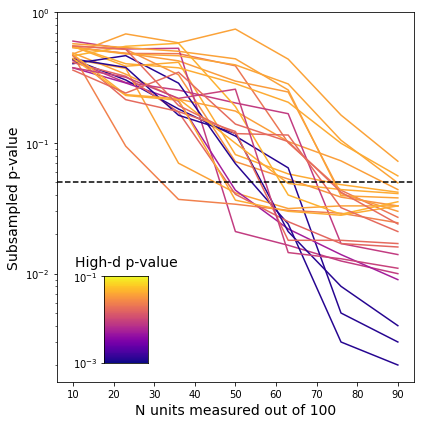

In [62]:
f, ax0 = plt.subplots(1, figsize=(6, 6))

axes_label_size = 14
title_size = 20
plot_label_size = 14

logminp = np.floor(np.log10(ambient_ps_sel.min()))
logmaxp = np.ceil(np.log10(ambient_ps_sel.max()))
logps = np.log10(ambient_ps_sel)
logps -= logminp
logps /= (logmaxp - logminp)
for ii in range(n_rots):
    ax0.plot(sample_dims, np.median(sample_ps[ii], axis=-1), c=plasma(logps[ii]))
#ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.axhline(5e-2, 0, 1, linestyle='--', c='k')
ax0.set_xlabel('N units measured out of {}'.format(ambient_dim), size=axes_label_size)
ax0.set_ylabel('Subsampled p-value', size=axes_label_size)
f.tight_layout()

ax1 = f.add_axes([.25, .15, .1, .2])
ax1.imshow(np.linspace(0, 1, 100)[::-1, np.newaxis], cmap='plasma', extent=[0, 1, 0, 1], aspect='auto')
ax1.set_xticks([])
ax1.set_yticks([0, 1])
ax1.set_yticklabels([r'$10^{}{}{}$'.format('{', int(val), '}') for val in [logminp, logmaxp]])
ax1.set_title('High-d p-value', pad=10, size=axes_label_size)

plt.savefig('dimensionality_subsampling.pdf', dpi=300)

(array([ 3.,  0.,  0.,  0.,  1.,  3.,  0.,  5.,  2., 11.]),
 array([-2.92081875, -2.76360908, -2.6063994 , -2.44918972, -2.29198005,
        -2.13477037, -1.97756069, -1.82035102, -1.66314134, -1.50593166,
        -1.34872199]),
 <a list of 10 Patch objects>)

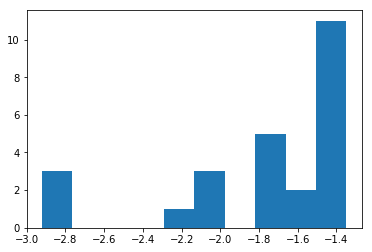

In [63]:
plt.hist(np.log10(ambient_ps_sel))

# sD_KL

In [ ]:
sample_dims = np.logspace(np.log10(2), np.log10(ambient_dim - 1), n_sample_dims, dtype=int)
ambient_vals = np.zeros(n_rots)
ambient_ps = np.zeros(n_rots)
sample_vals = np.zeros((n_rots, n_sample_dims, n_trials))
sample_ps = np.zeros((n_rots, n_sample_dims, n_trials))

_, vals, _ = null_models.eval_null(mu0, cov0, mu1, cov1,
                                   null_models.random_rotation, discriminability.mv_normal_jeffreys,
                                   n_null_samples)

for ii in range(n_rots):
    _, cov0p = null_models.random_rotation(mu0, cov0)
    _, cov1p = null_models.random_rotation(mu1, cov1)
    val = discriminability.mv_normal_jeffreys(mu0, cov0p, mu1, cov1p)
    ambient_vals[ii] = val
    ambient_ps[ii] = (vals >= val).mean()
    for jj, dim in enumerate(sample_dims):
        for kk in range(n_trials):
            (sample_mu0, sample_mu1), [sample_cov0p, sample_cov1p] = utils.subsample_cov([mu0, mu1], [cov0p, cov1p], dim, rng)
            val, _, p = null_models.eval_null(sample_mu0, sample_cov0p, sample_mu1, sample_cov1p,
                                              null_models.random_rotation, discriminability.mv_normal_jeffreys,
                                              n_null_samples)
            sample_vals[ii, jj, kk] = val
            sample_ps[ii, jj, kk] = p

In [ ]:
f, (ax0, ax1) = plt.subplots(1, 2)
for ii in range(n_rots):
    ax0.plot(sample_dims, sample_vals[ii].mean(axis=-1), c=plasma(ambient_ps[ii]))
ax0.set_xscale('log')
ax1.imshow(np.linspace(0, 1, 100)[::-1, np.newaxis], cmap='plasma', extent=[0, 1, 0, 1])
ax1.set_xticks([])

In [ ]:
f, (ax0, ax1) = plt.subplots(1, 2)
for ii in range(n_rots):
    ax0.plot(sample_dims, sample_ps[ii].mean(axis=-1), c=plasma(ambient_ps[ii]))
ax0.set_xscale('log')
ax0.set_yscale('log')
ax1.imshow(np.linspace(0, 1, 100)[::-1, np.newaxis], cmap='plasma', extent=[0, 1, 0, 1])
ax1.set_xticks([])